# Objectives:
1. For each Featurization(BOWs, TF-IDF) we need to split the data based on Time Based Slicing
   and apply Naive Bayes and find test accurcy.

2. Use 10-Fold Cross Validation to determine optimal alpha and apply Naive Bayes with optimal alpha
3. find feature importance ( top most words for deciding class labels positive or negative)
4. generate result matrices like accurecy , precision, F1 score, confusion matrix (TPR/FPR/FNR/TNR)

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string

In [10]:
final = final.sort_values(['Time'], ascending=[True])
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth about e...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel and funni movi keaton hilar...


In [11]:
positive_50000=final.loc[final['Score'] == "positive"].tail(50000)
negative_50000=final.loc[final['Score'] == "negative"].tail(50000)
pos_neg_1l = pd.concat([positive_50000, negative_50000], axis=0)
labels = pos_neg_1l['Score']

# Sort the sample values based on time

In [12]:
pos_neg_1l = pos_neg_1l.sort_values(['Time'], ascending=[True])
pos_neg_1l.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
288768,312780,B000FPFC4O,A77EO8HXDT3II,"Sawyer ""book lover""",1,1,negative,1248825600,Disappointing,I was very disappointed in the taste of these ...,b'was veri disappoint the tast these cooki ver...
192576,208809,B00004RAMV,A1RVL257CTT821,Carrie Armstrong,1,5,negative,1248825600,no bees,"I did what the guidlines suggested, and no bee...",b'did what the guidlin suggest and bee came ad...
177947,192959,B000ILA4KW,AQ5JDBXICB18J,R. Culp,0,0,negative,1248825600,Not impressed,I didn't have much luck with this popcorn in t...,b'didnt have much luck with this popcorn the m...
78622,85503,B002DHTWNO,A4UP3MT4NWCSS,"A. Tabachnik ""IDF""",9,13,negative,1248825600,The item contains MSG,The description for the item is wrong.<br />It...,b'the descript for the item wrong doe contain ...
114848,124563,B000UZLQG2,AQ5JDBXICB18J,R. Culp,1,3,negative,1248825600,Buttery flavor ???,Tastes too much like regular oil for me. I'm s...,b'tast too much like regular oil for still loo...


In [13]:
# dict = {"positive" : '1', "negative" : '0'}
# pos_neg_60k['Score1'] = pos_neg_1l['Score'].map(dict)
X = pos_neg_1l['CleanedText']
y = pos_neg_1l['Score']

In [14]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# BOW with NB

In [15]:
# BoW: A bag-of-words model, or BoW for short, is a way of extracting features from 
#      text for use in modeling, such as with machine learning algorithms.
#      It is called a “bag” of words, because any information about the order or structure of words 
#      in the document is discarded. The model is only concerned with whether known words occur in the document,
#      not where in the document.

# https://machinelearningmastery.com/gentle-introduction-bag-words-model/

# CountVectorizer: Convert a collection of text documents to a matrix of token counts.
#                  This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

###### CODE ######
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

In [16]:
# StandardScaler: Transforming data so that mean becomes 0 and std-dev becomes 1(so that to follow Gaussian Distribution)
# The StandardScaler applies the transformation  fnew=(f−f¯)/σf  to each dimension, 
# where  f¯  is the mean and  σf  the standard deviation for that dimension. 
# This will result in each dimension having a mean of 0 and a standard deviation of 1.
# Please note that when our data is stored in a sparse matrix, for instance when 
# we have a DictVectorizer or a CountVectorizer, the StandardScaler will be created with 
# the option with_mean=False. This means that we don't subtract  f¯ . The reason is 
# that we want to keep the matrix sparse: if an entry was zero before the transformation,
# we'd like it to be zero after the transformation also.

# the call fit_transform consists of a call to fit and then to transform. 
# In this case, fit will compute the mean and standard deviation, and then transform will apply the formula mentioned above.

###### CODE ######
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# The multinomial Naive Bayes classifier is suitable for classification with discrete features
# (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.
# However, in practice, fractional counts such as tf-idf may also work.

In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
y_pred = clf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 77%


# 10-Fold Cross Validation to find alpha

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.76846165  0.762034    0.76860449  0.78131695  0.76317669  0.76668095
  0.76325189  0.77539649  0.77182455  0.77182455]
[ 0.769033    0.76274818  0.76960434  0.78117412  0.76403371  0.76725246
  0.76396628  0.77553936  0.7721103   0.77196742]
[ 0.76931867  0.76346236  0.76946151  0.78131695  0.76460506  0.76725246
  0.76439491  0.77553936  0.77268181  0.77282469]
[ 0.76960434  0.76389087  0.76974718  0.78174546  0.76474789  0.76739534
  0.76468067  0.77639663  0.77311044  0.77325332]
[ 0.76989002  0.76417655  0.77046136  0.78160263  0.76503357  0.76796685
  0.76482355  0.77696814  0.77411059  0.7733962 ]
[ 0.7706042   0.76446222  0.77103271  0.78160263  0.76531924  0.76839549
  0.76482355  0.77725389  0.77439634  0.77396771]
[ 0.77074704  0.76503357  0.77146122  0.78203114  0.76574775  0.76853836
  0.76525218  0.7778254   0.7746821   0.77482497]
[ 0.77074704  0.7651764   0.77203257  0.78231681  0.76574775  0.76868124
  0.76525218  0.77796828  0.77453922  0.77511073]
[ 0.77103271  0.

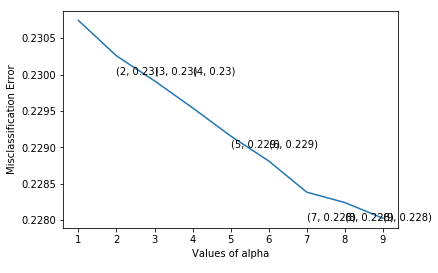

the misclassification error for each alpha value is :  [ 0.231  0.23   0.23   0.23   0.229  0.229  0.228  0.228  0.228]


In [21]:
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
# creating odd list of K for KNN
myList = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for a in myList:
    mnb = MultinomialNB(alpha=a)
    scores = cross_val_score(mnb, X_train.toarray(), y_train, cv=10, scoring='accuracy')
    print(scores)
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Values of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [23]:
# dump cv-score in a file
import pickle
pickle_out = open("cv_scores_nb.pickle","wb")
pickle.dump(cv_scores, pickle_out)
pickle_out.close()

In [24]:
mnb = MultinomialNB(alpha = optimal_alpha)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=9, class_prior=None, fit_prior=True)

In [25]:
y_pred = mnb.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 9 is %d%%' % (acc))


****Test accuracy for k = 5 is 77%


In [27]:
# Models like logistic regression, or Naive Bayes algorithm, predict the probabilities of observing some outcomes.
# In standard binary regression scenario the models give you probability of observing the "success" category. 
# In multinomial case, the models return probabilities of observing each of the outcomes. 
# Log probabilities are simply natural logarithms of the predicted probabilities.
# Empirical log probability of features given a class, P(x_i|y).
mnb.feature_log_prob_

array([[-11.02885423, -11.02885423, -14.44321285, ..., -11.02885423,
        -14.44321285, -14.44321285],
       [-14.30010865, -14.30010865, -10.88575003, ..., -14.30010865,
        -10.88575003, -10.88575003]])

In [28]:
sorted(mnb.feature_count_[0])[-10:]

[22195.611549675465,
 22651.679810131642,
 23369.83532074777,
 24316.557637544312,
 25857.62109103343,
 27283.425931007972,
 30322.198890403124,
 31484.058535013995,
 33347.253087793913,
 33422.712302017244]

In [29]:
sorted(mnb.feature_count_[1])[-10:]

[20091.865024666091,
 20782.685547414825,
 21482.826836358243,
 21946.178277279731,
 22106.548418216498,
 22979.230979129312,
 25344.269109398596,
 26028.280559340383,
 28447.774153617658,
 31865.442119707044]

In [30]:
# Number of samples encountered for each class during fitting. This value is weighted by the sample weight when provided.
mnb.class_count_

array([ 35055.,  34945.])

In [31]:
# Number of samples encountered for each (class, feature) during fitting. 
# This value is weighted by the sample weight when provided.
mnb.feature_count_[0]

array([ 264.57702095,  264.57702095,    0.        , ...,  264.57702095,
          0.        ,    0.        ])

# Find Most Important Features

In [22]:
def most_important_features(vectorizer, classifier, classlabel, n=20):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.feature_log_prob_[labelid], feature_names))[-n:]
    for coef, feat in topn:
        if feat not in stop:
            print(classlabel, feat, coef)
        else:
            continue

In [23]:
# Not considering stopwords while getting important words

stop = set(stopwords.words('english'))

In [37]:
most_important_features(count_vect, mnb, 'positive')

positive tri -6.84400788223
positive tast -6.83694219049
positive veri -6.80150380789
positive use -6.7897610457
positive like -6.70488150079
positive good -6.58881509383
positive love -6.49329703454
positive great -6.45459555561


In [38]:
most_important_features(count_vect, mnb, 'negative')

negative one -6.84270659598
negative would -6.80145595237
negative product -6.73907008184
negative like -6.6323821487
negative tast -6.58085100386


In [39]:
from sklearn.metrics import classification_report
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.78      0.78      0.78     14945
   positive       0.78      0.78      0.78     15055

avg / total       0.78      0.78      0.78     30000



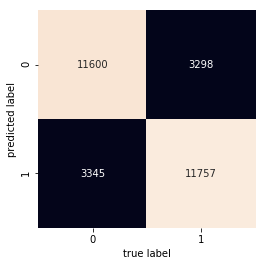

In [41]:
from sklearn.metrics import confusion_matrix
%matplotlib inline  
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# BOW with NB for whole DataSet

In [11]:
X = final['CleanedText']
y = final['Score']

In [12]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

In [15]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha = 1)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [16]:
y_pred = mnb.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


****Test accuracy for k = 1 is 90%


In [24]:
most_important_features(count_vect, mnb, 'positive')

positive love -5.12313875768
positive flavor -5.10955015809
positive good -5.07384586882
positive tast -4.93943452613
positive like -4.86256928879


In [25]:
most_important_features(count_vect, mnb, 'negative')

negative flavor -5.27578819374
negative one -5.21686552263
negative product -4.89350013145
negative like -4.76050349988
negative tast -4.69858668915


In [26]:
from sklearn.metrics import classification_report
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.69      0.70      0.70     17213
   positive       0.94      0.94      0.94     92039

avg / total       0.90      0.90      0.90    109252



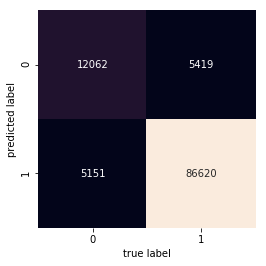

In [27]:
from sklearn.metrics import confusion_matrix
%matplotlib inline  
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TimeSeries based cross validation split with gridsearchCV

In [28]:
# Why is Cross-Validation Different with Time Series?

# When dealing with time series data, traditional cross-validation (like k-fold) should not be used for two reasons:
# https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# creating odd list of K for KNN
myList = list(range(1,10))
#alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# empty list that will hold cv scores
cv_scores = []
parameters = [{'alpha': myList}]

# perform 10-fold cross validation

mnb = MultinomialNB()
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
gsearch = GridSearchCV(mnb, cv=my_cv, param_grid=parameters, scoring='accuracy')
gsearch.fit(X_train, y_train)
print(gsearch)
# Print the tuned parameter and score
print("Tuned Hyperparameter Parameters: {}".format(gsearch.best_params_))
print("Best score is {}".format(gsearch.best_score_))

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f504af954c0>,
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Tuned Hyperparameter Parameters: {'alpha': 1}
Best score is 0.9035340637614301


# TF-IDF with NB

In [42]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [43]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_tfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidf)

In [44]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(final_tf_idf_train)
# transform both train and test data
final_tf_idf_train = scaler.transform(final_tf_idf_train)
final_tf_idf_test = scaler.transform(final_tf_idf_test)

[ 0.78160263  0.78217398  0.78403085  0.78374518  0.78903014  0.78882698
  0.79297042  0.78425489  0.79039863  0.78025432]
[ 0.78803028  0.79088702  0.78988716  0.79131553  0.79474361  0.79597085
  0.79782826  0.79168453  0.79582798  0.78768395]
[ 0.79174404  0.79488644  0.79488644  0.79645765  0.79845736  0.80125732
  0.80154308  0.79611373  0.80040006  0.79225604]
[ 0.79602914  0.79845736  0.79802885  0.80102842  0.80202828  0.80525789
  0.80525789  0.79954279  0.80411487  0.79554222]
[ 0.79888587  0.80145693  0.80117126  0.80431367  0.80531353  0.80782969
  0.80754393  0.80197171  0.8058294   0.79897128]
[ 0.8013141   0.80545636  0.80374232  0.80745608  0.80917012  0.80911559
  0.81068724  0.80468638  0.80797257  0.8001143 ]
[ 0.80388516  0.80645622  0.80588487  0.80874161  0.81116983  0.81054436
  0.81240177  0.80611516  0.80925847  0.80311473]
[ 0.80459934  0.80674189  0.80802742  0.81131267  0.81331238  0.81397342
  0.81525932  0.80868696  0.81140163  0.80511502]
[ 0.80502785  0.

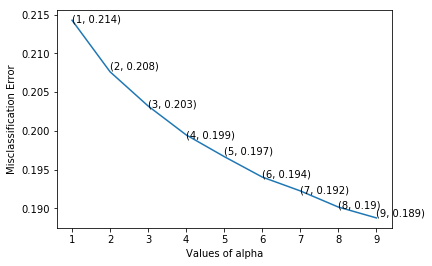

the misclassification error for each alpha value is :  [ 0.214  0.208  0.203  0.199  0.197  0.194  0.192  0.19   0.189]


In [55]:
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
# creating odd list of K for KNN
myList = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for a in myList:
    mnb = MultinomialNB(alpha=a)
    scores = cross_val_score(mnb, final_tf_idf_train, y_train_tfidf, cv=10, scoring='accuracy')
    print(scores)
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Values of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [56]:
mnb = MultinomialNB(alpha = optimal_alpha)
mnb.fit(final_tf_idf_train, y_train_tfidf)

MultinomialNB(alpha=9, class_prior=None, fit_prior=True)

In [57]:
# Predicting the Test set results
y_pred = mnb.predict(final_tf_idf_test)

In [58]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 9 is %d%%' % (acc))


****Test accuracy for k = 9 is 74%


In [50]:
most_important_features(tf_idf_vect, mnb, 'positive')

positive veri -9.2882680974
positive tast -9.26373367382
positive use -9.17713029225
positive like -9.15713971073
positive good -9.05719579168
positive great -8.97286239284
positive love -8.95351724708


In [51]:
most_important_features(tf_idf_vect, mnb, 'negative')

negative one -9.32587306646
negative would -9.28560015586
negative product -9.19950858645
negative like -9.0816987971
negative tast -9.02859104997


In [52]:
from sklearn.metrics import classification_report
y_pred = mnb.predict(final_tf_idf_test)
print(classification_report(y_test_tfidf, y_pred))

             precision    recall  f1-score   support

   negative       0.73      0.78      0.76     14945
   positive       0.77      0.72      0.74     15055

avg / total       0.75      0.75      0.75     30000



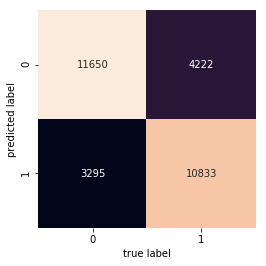

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TF-IDF with NB for whole DataSet

In [31]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_tfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidf)

In [33]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(final_tf_idf_train)
# transform both train and test data
final_tf_idf_train = scaler.transform(final_tf_idf_train)
final_tf_idf_test = scaler.transform(final_tf_idf_test)

In [34]:
mnb = MultinomialNB(alpha = 1)
mnb.fit(final_tf_idf_train, y_train_tfidf)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [35]:
# Predicting the Test set results
y_pred = mnb.predict(final_tf_idf_test)

In [38]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


****Test accuracy for k = 1 is 83%


In [37]:
most_important_features(tf_idf_vect, mnb, 'positive')

positive use -9.50327340433
positive tast -9.3856518648
positive good -9.37507304524
positive great -9.36725986626
positive like -9.36047794734
positive love -9.3442440461


In [39]:
most_important_features(tf_idf_vect, mnb, 'negative')

negative would -9.47662892962
negative product -9.41684211432
negative disappoint -9.40265654614
negative like -9.32956373498
negative tast -9.23272104644


In [40]:
from sklearn.metrics import classification_report
y_pred = mnb.predict(final_tf_idf_test)
print(classification_report(y_test_tfidf, y_pred))

             precision    recall  f1-score   support

   negative       0.49      0.36      0.42     17213
   positive       0.89      0.93      0.91     92039

avg / total       0.82      0.84      0.83    109252



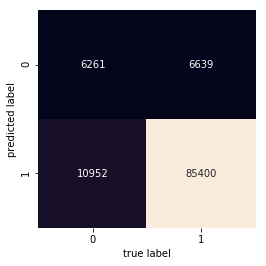

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TimeSeries based cross validation split with gridsearchCV

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# creating odd list of K for KNN
myList = list(range(1,10))
#alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# empty list that will hold cv scores
cv_scores = []
parameters = [{'alpha': myList}]

# perform 10-fold cross validation

mnb = MultinomialNB()
my_cv = TimeSeriesSplit(n_splits=2).split(final_tf_idf_train)
gsearch = GridSearchCV(mnb, cv=my_cv, param_grid=parameters, scoring='accuracy')
gsearch.fit(final_tf_idf_train, y_train_tfidf)
print(gsearch)
# Print the tuned parameter and score
print("Tuned Hyperparameter Parameters: {}".format(gsearch.best_params_))
print("Best score is {}".format(gsearch.best_score_))

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f508614b780>,
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Tuned Hyperparameter Parameters: {'alpha': 1}
Best score is 0.7192578819154319


# Conclusion:

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "hyper parameter- alpha", "train error", "test error"]
x.add_row(["NB-BOW", 9, "", "23%"])
x.add_row(["NB-TFIDF", 9, "", "26%"])
print("Featurization With Naive Bayes:")
print(x)

Featurization With Naive Bayes:
+----------+------------------------+-------------+------------+
|  Model   | hyper parameter- alpha | train error | test error |
+----------+------------------------+-------------+------------+
|  NB-BOW  |           9            |             |    23%     |
| NB-TFIDF |           9            |             |    26%     |
+----------+------------------------+-------------+------------+


In Naive Bayes our assumption is that each word is independent of each other. we have used two featurization 
BOW and TFIDF to convert text to vector. Applying Naive Bayes we could see 77% accuracy for BOW and 74% accuracy 
for TFIDF.